In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# --- Parameters ---
IMG_SIZE = 224
EMBEDDING_DIM = 128
BATCH_SIZE = 32
EPOCHS = 15
DATASET_PATH = r"C:\Users\NIT\Downloads\archive (8)\SOCOFing\SOCOFing\Real"

# --- Load & preprocess ---
def load_image_and_label(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img)  # contrast enhancement
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    filename = os.path.basename(path)
    identity = int(filename.split('_')[0])
    return img, identity

# Load images and labels
X, Y_id = [], []
for fname in os.listdir(DATASET_PATH):
    if fname.endswith(".BMP"):
        img, identity = load_image_and_label(os.path.join(DATASET_PATH, fname))
        X.append(img)
        Y_id.append(identity)

X = np.array(X)
Y_id = np.array(Y_id)

# Encode labels
le = LabelEncoder()
Y_id_encoded = le.fit_transform(Y_id)
Y_onehot = tf.keras.utils.to_categorical(Y_id_encoded)
NUM_CLASSES = Y_onehot.shape[1]

# Train/val split
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y_onehot, test_size=0.2, stratify=Y_id_encoded, random_state=42
)

# --- ArcFace Layer ---
class ArcFace(layers.Layer):
    def __init__(self, num_classes, s=30.0, m=0.50, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        embedding_dim = input_shape[0][-1]
        self.W = self.add_weight(name='W',
                                 shape=(embedding_dim, self.num_classes),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        x, y = inputs
        x = tf.math.l2_normalize(x, axis=1)
        W = tf.math.l2_normalize(self.W, axis=0)
        logits = tf.matmul(x, W)
        theta = tf.acos(tf.clip_by_value(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = tf.cos(theta + self.m)
        output = logits * (1 - y) + target_logits * y
        return self.s * output

# --- Build Model ---
def build_arcface_model(num_classes, input_shape=(224, 224, 1), embedding_dim=128):
    base_inputs = layers.Input(shape=input_shape, name='image_input')
    x = layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(base_inputs)

    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    # Fine-tune last layers
    for layer in base_model.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    embedding = layers.Dense(embedding_dim, activation=None, name='embedding')(x)

    labels_input = layers.Input(shape=(num_classes,), name='labels_input')
    arcface_logits = ArcFace(num_classes)([embedding, labels_input])
    output = layers.Softmax()(arcface_logits)

    model = tf.keras.Model(inputs=[base_inputs, labels_input], outputs=output)
    embedding_model = tf.keras.Model(inputs=base_inputs, outputs=embedding)

    return model, embedding_model

# --- Prepare Dataset ---
train_ds = tf.data.Dataset.from_tensor_slices(((X_train, Y_train), Y_train)) \
    .shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val, Y_val), Y_val)) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Build, Compile, Train ---
model, embedding_model = build_arcface_model(NUM_CLASSES)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ModelCheckpoint('best_arcface_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# --- Embedding Cosine Similarity Example ---
def cosine_sim(a, b):
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    return np.dot(a, b)

emb1 = embedding_model.predict(X_val[0:1])
emb2 = embedding_model.predict(X_val[1:2])
print("Cosine similarity:", cosine_sim(emb1[0], emb2[0]))





Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0000e+00 - loss: 23.1713

150/150 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.0000e+00 - loss: 23.1663 - val_accuracy: 0.0000e+00 - val_loss: 23.8242 - learning_rate: 1.0000e-04
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.0000e+00 - loss: 19.5278 - val_accuracy: 0.0000e+00 - val_loss: 23.9330 - learning_rate: 1.0000e-04
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 2.8541e-05 - loss: 16.8993 - val_accuracy: 0.0000e+00 - val_loss: 23.8740 - learning_rate: 1.0000e-04
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0027 - loss: 13.4989
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
150/150 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.0027 - loss: 13.4950 - val_accuracy: 0.0000e+00 - val_loss: 24.0583 - learning_rate: 1.0000e-04
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.0517 - loss: 8.2173 - val_accuracy: 0.0000e+00 - val_loss: 24.1856 - learning_rate: 5.0000e-05
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━

150/150 ━━━━━━━━━━━━━━━━━━━━ 9502s 64s/step - accuracy: 0.9956 - loss: 0.1062 - val_accuracy: 8.3333e-04 - val_loss: 20.4019 - learning_rate: 5.0000e-05
Epoch 12/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9950 - loss: 0.1075 - val_accuracy: 8.3333e-04 - val_loss: 19.9858 - learning_rate: 5.0000e-05
Epoch 13/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.9960 - loss: 0.0966 - val_accuracy: 8.3333e-04 - val_loss: 19.8974 - learning_rate: 5.0000e-05
Epoch 14/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9966 - loss: 0.0733

150/150 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.9966 - loss: 0.0734 - val_accuracy: 0.0025 - val_loss: 19.8569 - learning_rate: 5.0000e-05
Epoch 15/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.9959 - loss: 0.0847 - val_accuracy: 0.0025 - val_loss: 19.8614 - learning_rate: 5.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Cosine similarity: -0.028629575


ValueError: No such layer: conv5_block3_out. Existing layers are: ['image_input', 'lambda', 'resnet50', 'global_average_pooling2d', 'batch_normalization', 'embedding', 'labels_input', 'arc_face', 'softmax'].

Text(0.5, 1.0, 'Grad-CAM Visualization')

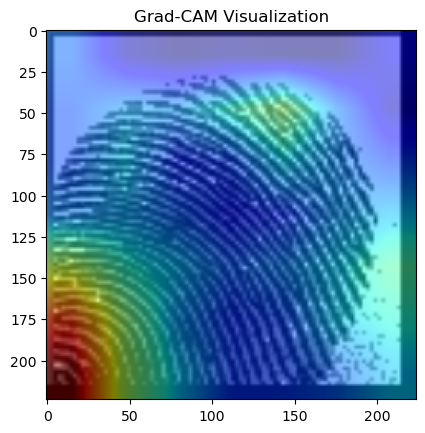

In [5]:
def make_gradcam_heatmap(img_array, model, conv_layer_name="conv5_block3_out"):
    # Get the ResNet50 base model from the ArcFace model
    backbone = model.get_layer("resnet50")

    # Create submodel for Grad-CAM from the image input to ResNet outputs
    grad_model = tf.keras.models.Model(
        inputs=backbone.input,
        outputs=[backbone.get_layer(conv_layer_name).output, backbone.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = tf.reduce_mean(predictions, axis=-1)  # can also use specific class

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# --- Visualize Grad-CAM ---
img_input = np.expand_dims(X_val[0], axis=0)  # Shape: (1, 224, 224, 1)
img_input_rgb = np.repeat(img_input, 3, axis=-1)  # Convert grayscale to RGB

heatmap = make_gradcam_heatmap(img_input_rgb, model)

# Plot
plt.imshow(X_val[0].squeeze(), cmap='gray')
plt.imshow(cv2.resize(heatmap, (224, 224)), alpha=0.5, cmap='jet')
plt.title("Grad-CAM Visualization")